In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import scale

## Load Data

In [2]:
df_retail = pd.read_csv('./retail_transactions.csv', encoding='ISO-8859-1')

df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Prepare Data

In [3]:
df_retail['total'] = df_retail['Quantity'] * df_retail['UnitPrice']
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [4]:
retail_group = (df_retail.groupby('CustomerID').agg({"InvoiceNo": pd.Series.nunique, "total": np.sum})
    .rename(columns={'InvoiceNo':'invoice_count','total':'invoice_amt_total'})
    .reset_index(drop=True))

In [5]:
retail_group.head()

,invoice_count,invoice_amt_total
0,2,0.00
1,7,4310.00
2,4,1797.24
3,1,1757.55
4,1,334.40


In [6]:
# Filter only positive invoices

retail_group = retail_group[retail_group['invoice_amt_total']>0]
retail_group.describe()

,invoice_count,invoice_amt_total
count,4322.000000,4.322000e+03
mean,5.115687,1.923483e+03
std,9.384459,8.263128e+03
min,1.000000,1.243450e-14
25%,1.000000,3.022925e+02
50%,3.000000,6.575500e+02
75%,6.000000,1.625740e+03
max,248.000000,2.794890e+05


In [7]:
x = retail_group
x[x.columns] = scale(x[x.columns])
x.head()

,invoice_count,invoice_amt_total
1,0.200814,0.288849
2,-0.118900,-0.015280
3,-0.438615,-0.020084
4,-0.438615,-0.192332
5,0.627100,-0.045760


In [8]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, random_state=1)
model.fit(x)
kMeans_labels = model.labels_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

## Display kmeans cluster on scatter plot

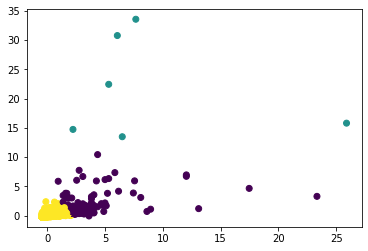

In [9]:
plt.scatter(x['invoice_count'], x['invoice_amt_total'],c=kMeans_labels)

## Evaluate quality of clusters

In [10]:
from sklearn.metrics import silhouette_score

silhouette_score(x, kMeans_labels)

0.8702675789179637

In [11]:
# Function for k-means clustering

def cluster_kMeans(x, k):
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(x)
    kMeans_labels = model.labels_
    kMeans_sil_score = silhouette_score(x, kMeans_labels)
    return (kMeans_labels, kMeans_sil_score)

In [12]:
# Iterate over differenv values of ka to determine the one giving the highest silhouette score

for k in range(2,6):
    kMeans_labels, kMeans_sil_score = cluster_kMeans(x,k)
    print('k: ', k, '\t\t', 'Silhoutte score:', kMeans_sil_score)

k:  2 		 Silhoutte score: 0.9500287241902932
k:  3 		 Silhoutte score: 0.8702675789179637
k:  4 		 Silhoutte score: 0.7664562049850545
k:  5 		 Silhoutte score: 0.7548345285634424


In [13]:
## Hierarchical Clustering

In [14]:
from sklearn.cluster import AgglomerativeClustering

h_model = AgglomerativeClustering(n_clusters=3)
h_model.fit(x)
hCluster_labels = h_model.labels_

silhouette_score(x, hCluster_labels)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=3)

0.9431829024504798

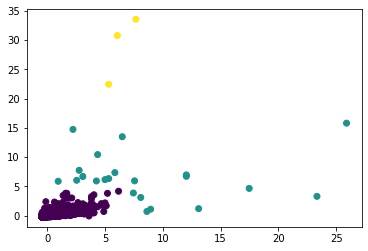

In [15]:
plt.scatter(x['invoice_count'], x['invoice_amt_total'],c=hCluster_labels)

In [16]:
def cluster_hCluster(x, k):
    model = AgglomerativeClustering(n_clusters=k)
    model.fit(x)
    hCluster_labels = model.labels_
    hCluster_sil_score = silhouette_score(x, hCluster_labels)
    return (hCluster_labels, hCluster_sil_score)

In [17]:
for k in range(2,6):
    hCluster_labels, hCluster_sil_score = cluster_hCluster(x,k)
    print('k: ', k, '\t\t', 'Silhoutte score:', hCluster_sil_score)

k:  2 		 Silhoutte score: 0.9506143839088965
k:  3 		 Silhoutte score: 0.9431829024504798
k:  4 		 Silhoutte score: 0.7878666664053137
k:  5 		 Silhoutte score: 0.7886621064730744


## DBSCAN

In [18]:
from sklearn.cluster import DBSCAN

db_model = DBSCAN(eps=0.5)
db_model.fit(x)
dbscan_labels = db_model.labels_

silhouette_score(x, dbscan_labels)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

0.8266426230939371

In [19]:
dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
dbscan_noise = list(dbscan_labels).count(-1)

print('Clusters: ', dbscan_clusters, '\t\t', 'Noise: ', dbscan_noise)

Clusters:  3 		 Noise:  43


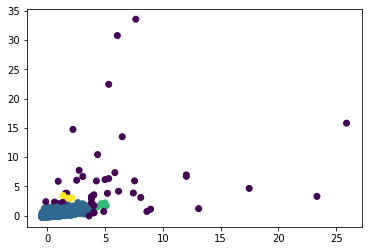

In [20]:
plt.scatter(x['invoice_count'], x['invoice_amt_total'],c=dbscan_labels)